In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import cartopy.crs as ccrs
import cmocean.cm as cmo
import copernicusmarine as cm
import dask
from IPython.display import HTML
import jax
import jax.numpy as jnp
import matplotlib.animation as manimation
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import jaxparrow as jpw
from jaxparrow.utils import kinematics

/Users/bertrava/miniconda3/envs/jaxparrow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The aim of this notebook is to illustrate how `jaxparrow` can be employed to derive cyclogeostrophic currents on a C-grid from Sea Surface Height (SSH) observations.

We use the Global Ocean Gridded L4 Sea Surface Heights And Derived Variables Reprocessed dataset ([description](https://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_MY_008_047/description), [reference](https://doi.org/10.48670/moi-00148)).  
This product provides daily average of SSH, and geostrophic currents, on a rectilinear A-grid, with a spatial resolution of 1/8°.

## Accessing DUACS data

Copernicus Marine datasets can be accessed through the [Copernicus Marine Toolbox](https://help.marine.copernicus.eu/en/collections/4060068-copernicus-marine-toolbox) API.

The API allows to remotely access subsets of the datasets by restricting the spatial and temporal domain, and the variables.
We focus on the month of June 2019.

In [ ]:
dataset_options = {
    "dataset_id": "cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D",
    "variables": ["adt", "ugos", "vgos"],
    "start_datetime": "2019-06-01T00:00:00",
    "end_datetime": "2019-06-30T23:59:59"
}
duacs_ds = cm.open_dataset(**dataset_options)

INFO - 2025-11-27T08:14:59Z - Selected dataset version: "202411"
INFO - 2025-11-27T08:14:59Z - Selected dataset part: "default"


Below is a snpashot of the 15 Jun 2019 sea surface height (SSH) over the global ocean, as provided by the DUACS dataset.

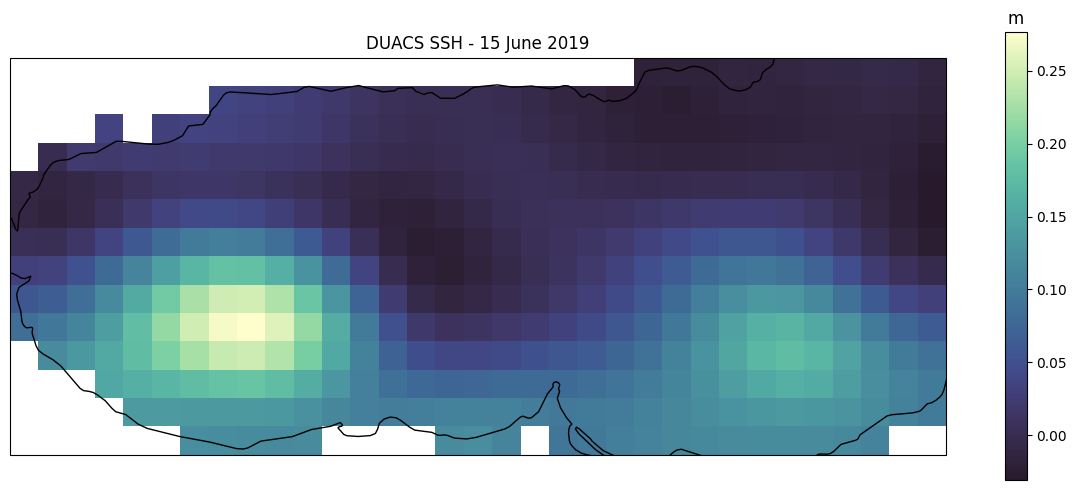

In [4]:
ds = duacs_ds.sel(time=np.datetime64("2019-06-15T00:00:00"))

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(12, 5))

ax.set_title("DUACS SSH - 15 June 2019")
im = ax.pcolormesh(ds.longitude, ds.latitude, ds.adt, cmap=cmo.deep_r)
ax.coastlines()

clb = plt.colorbar(im, ax=ax)
_ = clb.ax.set_title("m")

fig.tight_layout()
plt.show()

## Reconstructing cyclogeostrophic currents using `jaxparrow`

`jaxparrow` uses C-grids, following NEMO convention. U, V, and F points are automatically derived from the T points.

In [5]:
lon_t, lat_t = jnp.meshgrid(duacs_ds.longitude.values, duacs_ds.latitude.values)

We compute the cyclogeostrophic currents using the function [`jaxparrow.cyclogeostrophy.cyclogeostrophy`][].
By default the method being used it the minimization-based one.

Rather than looping over our time indices, we could vectorise the function [`jaxparrow.cyclogeostrophy.cyclogeostrophy`][] over the time axis thanks to `jax.vmap` and compute the cyclogeostrophic currents at every time point using the vectorise version.
However, for one month of global data, even with a relatively large spatio-temporal resolution, it is unlikely to have enough RAM or VRAM to perform the inversion at once for the whole timeperiod.
Therefore, we use `dask.array.map_blocks` to apply the inversion using `jax.vmap` to batches of SSH maps.

Because we will only visualize the results, we compute and return the magnitude of the velocity, and not its two components $u$ and $v$.

In [6]:
@jax.vmap
def vmap_inversion(ssh):
    ucg, vcg, ug, vg = jpw.cyclogeostrophy(ssh, lat_t, lon_t, return_geos=True, return_grids=False)

    # for visualisation purposes we are only interested in the magnitude
    uvcg = kinematics.magnitude(ucg, vcg)
    uvc = kinematics.magnitude(ucg - ug, vcg - vg)  # for plotting the cyclostrophic part only

    return uvcg, uvc


def batch_inversion(in_block):
    uvcg, uvc = vmap_inversion(jnp.asarray(in_block.adt.values))

    out_block = xr.Dataset(
        {
            "uvcg": (in_block.adt.dims, np.asarray(uvcg)),
            "uvc": (in_block.adt.dims, np.asarray(uvc)),
        }
    )

    return out_block


BATCH_SIZE = 10

duacs_ds = duacs_ds.chunk(chunks={"time": BATCH_SIZE, "latitude": -1, "longitude": -1})

nt = duacs_ds.time.size
ny = duacs_ds.latitude.size
nx = duacs_ds.longitude.size

empty_arr = dask.array.empty((nt, ny, nx), chunks=(BATCH_SIZE, ny, nx), dtype=np.float32)
template = xr.Dataset(
    {
        "uvcg": (list(duacs_ds.dims), empty_arr),
        "uvc": (list(duacs_ds.dims), empty_arr),
    },
)

with dask.config.set(scheduler="synchronous"):
    inversion_result = xr.map_blocks(batch_inversion, duacs_ds, template=template)
    inversion_result = inversion_result.assign_coords({
        "time": duacs_ds.time,
        "latitude": duacs_ds.latitude,
        "longitude": duacs_ds.longitude,
    })
    inversion_result = inversion_result.compute()  # force computation inside the context manager

Below we animate the cyclogeostrophic currents magnitude over the month of June 2019.

In [9]:
def draw_frame(i):
    im.set_array(np.ravel(inversion_result.uvcg.isel(time=i)))
    return [im,]


def init_func():
    return draw_frame(0)


plt.ioff()

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(12, 5))

ax.set_title("$\| \\vec{u}_{cg} \|$")
im = ax.pcolormesh(
    inversion_result.longitude, inversion_result.latitude, inversion_result.uvcg.isel(time=0), 
    vmax=1.25, vmin=0, cmap=cmo.speed
)
ax.coastlines()

clb = fig.colorbar(im, ax=ax, extend="max")
_ = clb.ax.set_title("m/s")

fig.tight_layout()

anim = manimation.FuncAnimation(fig, draw_frame, init_func=init_func, frames=nt, interval=250, blit=True)
HTML(anim.to_html5_video())

And we can also visualize only the cyclostrophic ($\vec{u}_c = \vec{u}_{cg} - \vec{u}_g$) part of the currents.

In [10]:
def draw_frame(i):
    im.set_array(np.ravel(inversion_result.uvc.isel(time=i)))
    return [im,]


def init_func():
    return draw_frame(0)


plt.ioff()

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(12, 5))

ax.set_title("$\| \\vec{u}_c \|$")
im = ax.pcolormesh(
    inversion_result.longitude, inversion_result.latitude, inversion_result.uvc.isel(time=0), 
    vmax=0.3, vmin=0, cmap=cmo.speed
)
ax.coastlines()

clb = fig.colorbar(im, ax=ax, extend="max")
_ = clb.ax.set_title("m/s")

fig.tight_layout()

anim = manimation.FuncAnimation(fig, draw_frame, init_func=init_func, frames=nt, interval=250, blit=True)
HTML(anim.to_html5_video())